 In this notebook we will show how to apply albumentations to the keypoint problem.


Keypoints augmentations are implemented for spatial transformations of:
 * VerticalFlip
 * HorizontalFlip
 * Flip
 * RandomCrop
 * RandomRotate90
 * Rotate
 * CenterCrop
 * RandomSizedCrop
 * ShiftScaleRotate
 
Any combination of the above transformations and non spatial transformations can be used.


Spatial transformations that do **NOT** support keypoint transformations at the moment are:
* Crop
* LongestMaxSize
* SmallestMaxSize
* Resize

We are planning to implement them, but if someone is willing to implement them and create a Pull Request, it would make use happy :)

In [2]:
%matplotlib inline
from urllib.request import urlopen
from matplotlib import pyplot as plt

import albumentations as albu
import numpy as np
import cv2
import os

In [3]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
def vis_points(image, points, diameter=15):
    im = image.copy()

    for (x, y) in points:
        cv2.circle(im, (int(x), int(y)), diameter, (0, 255, 0), -1)

    plt.imshow(im)

In [5]:
def create_transformer(transformations):
    return albu.Compose(transformations, p=1, 
                        keypoint_params=albu.KeypointParams(format='xy'))(image=image, keypoints=points)

In [6]:
image = download_image('https://habrastorage.org/webt/_m/8j/vb/_m8jvb11szwten8kxx5a5rgkhcw.jpeg')

In [7]:
points = [(100, 100), (720, 410), (1100, 400), (1700, 30), 
          (300, 650), (1570, 590), (560, 800), (1300, 750), 
          (900, 1000), (910, 780), (670, 670), (830, 670), 
          (1000, 670), (1150, 670), (820, 900), (1000, 900)]

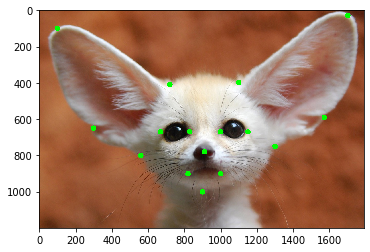

In [8]:
vis_points(image, points) # gắn những điểm vào trong ảnh 

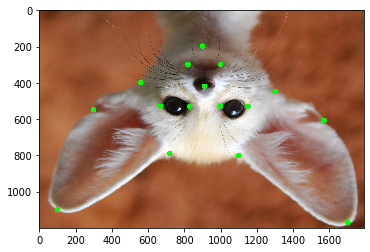

In [9]:
transformed = create_transformer([albu.VerticalFlip(p=1)])

keypoints = transformed['keypoints'] # gán vào dict với albu.VerticalFlip lật dọc
im = transformed['image']
vis_points(im, keypoints)

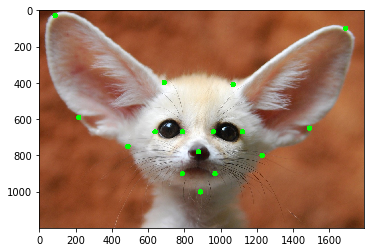

In [10]:
transformed = create_transformer([albu.HorizontalFlip(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

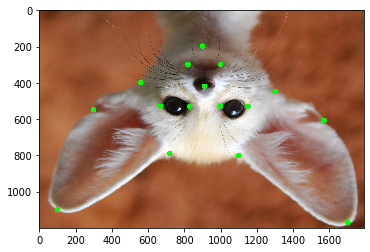

In [11]:
transformed = create_transformer([albu.Flip(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

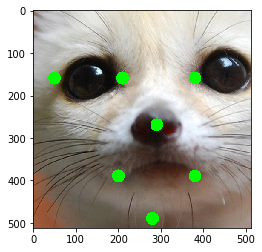

In [12]:
transformed = create_transformer([albu.RandomCrop(width=512, height=512, p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

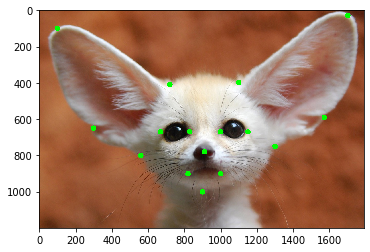

In [13]:
transformed = create_transformer([albu.RandomRotate90(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

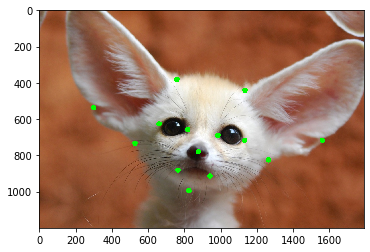

In [14]:
transformed = create_transformer([albu.Rotate(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

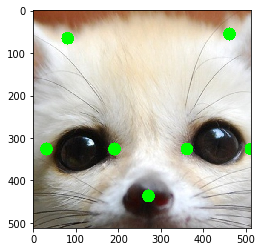

In [15]:
transformed = create_transformer([albu.CenterCrop(height=512, width=512, p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

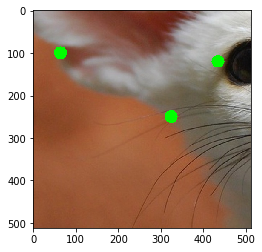

In [16]:
transformed = create_transformer([albu.RandomSizedCrop(min_max_height=(256, 1025), height=512, width=512, p=1)])

keypoints = transformed['keypoints']
im = transformed['image']


vis_points(im, keypoints)

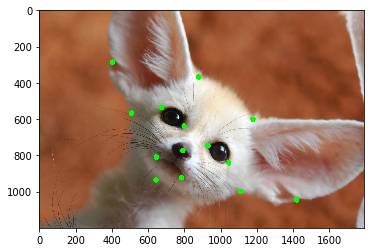

In [17]:
transformed = create_transformer([albu.ShiftScaleRotate(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']

vis_points(im, keypoints)

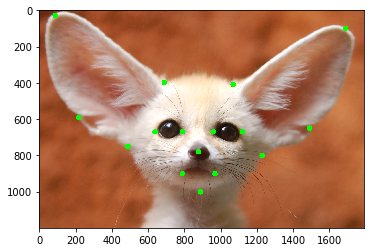

In [20]:
transformed = create_transformer([albu.RandomSizedCrop(min_max_height=(256, 1025), height=512, width=512, p=0.5),
                            albu.HorizontalFlip(p=0.5),
                            albu.OneOf([albu.HueSaturationValue(p=0.5), 
                                        albu.RGBShift(p=0.7)], p=1),                          
                            albu.RandomBrightnessContrast(p=0.5)])

keypoints = transformed['keypoints']
im = transformed['image']


vis_points(im, keypoints)

In this notebook we will show how to apply albumentations to the case when the same transformation can be applied to different targets.

More details at https://albumentations.readthedocs.io/en/latest/api/core.html#albumentations.core.composition.Compose

For example, we can apply the same rotation to: 
* image1, image2, ... imageN, 
* bboxes1, bboxes2, ... bboxesM
* keypoints1, keypoints2, ... keypointsK
* mask1, mask2, ..., maskL

The trick is to define additional target dictionary that maps new targets on the default one.

For example:
```python
transform = albu.Compose(transformations, 
                         p=1, 
                         additional_targets={
    'image1': 'image',
    'image2': 'image',
    ...
    'imageN': 'image',

    'bboxes1': 'bboxes',
    'bboxes1': 'bboxes',
    ...
    'bboxesM': 'bboxes',

    'keypoints1': 'keypoints',
    'keypoints2': 'keypoints',
    ...
    'keypointsK': 'keypoints',

    'mask1': 'mask',
    'mask2': 'mask',
    ...
    'maskL': 'mask'
    })
```

In [21]:
%matplotlib inline
from urllib.request import urlopen
from matplotlib import pyplot as plt

import albumentations as albu
import numpy as np
import cv2
import os

In [22]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [23]:
image = download_image('https://habrastorage.org/webt/en/h4/14/enh414tt02dbgivt0vjnn2ztrg8.jpeg')
image0 = download_image('https://habrastorage.org/webt/_r/cm/gv/_rcmgvkes5hubvgsyppl9hn5ydw.jpeg')
image1 = download_image('https://habrastorage.org/webt/4i/hb/aj/4ihbajlpywjq151jf2eqydxofbk.jpeg')

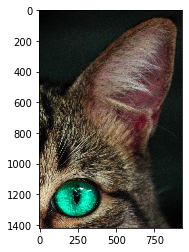

In [24]:
plt.imshow(image)

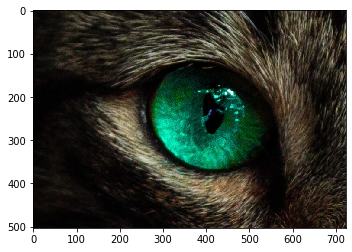

In [25]:
plt.imshow(image0)

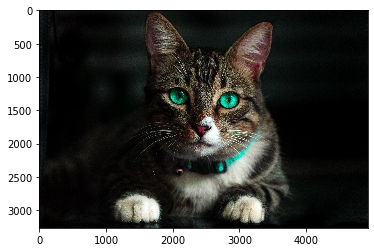

In [26]:
plt.imshow(image1)

In [27]:
images = [image, image0, image1]

In [28]:
def create_transformer(transformations, images):
    target = {}
    for i, image in enumerate(images[1:]):
        target['image' + str(i)] = 'image'
    return albu.Compose(transformations, p=1, additional_targets=target)(image=images[0],
                                                                        image0=images[1],
                                                                        image1=images[2])

In [29]:
transformed = create_transformer([albu.VerticalFlip(p=1)], images)

im = transformed['image']
im0 = transformed['image0']
im1 = transformed['image1']

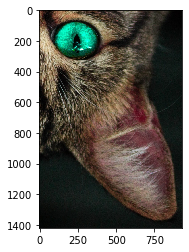

In [30]:
plt.imshow(im)

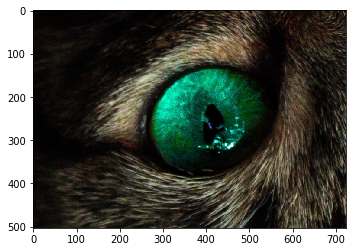

In [31]:
plt.imshow(im0)

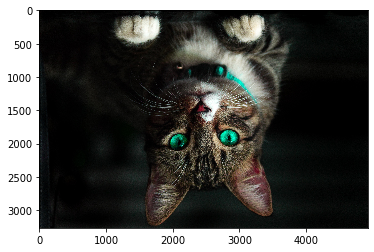

In [32]:
plt.imshow(im1)

In [ ]:
%matplotlib inline
from urllib.request import urlopen

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [ ]:
import albumentations as albu

In [38]:
path__ = '/home/manhduy/Documents/model_DL/envData_Augmentation/data_augmentation/images/c.jpg'

In [40]:
image = cv2.imread(path__)[:,:,::-1]

In [42]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(20, 10))
    plt.imshow(image)

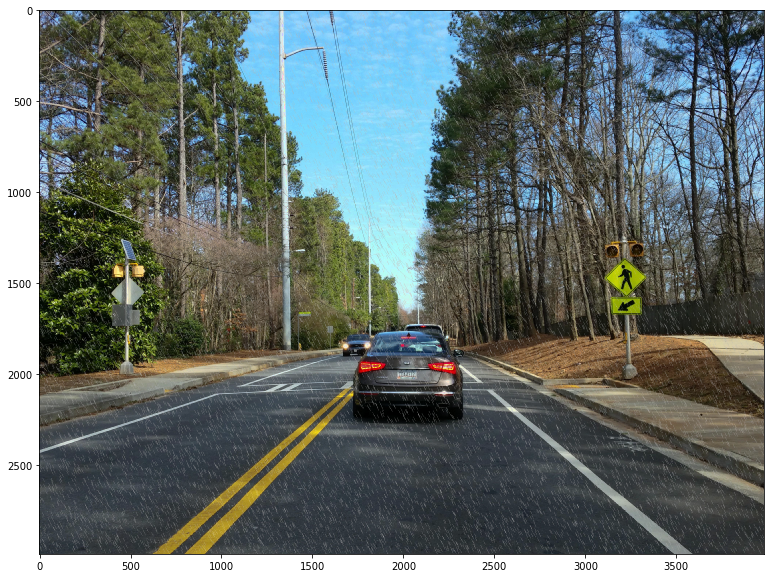

In [43]:
aug = albu.RandomRain(p=1, brightness_coefficient=0.9, drop_width=1, blur_value=5)
augment_and_show(aug, image)

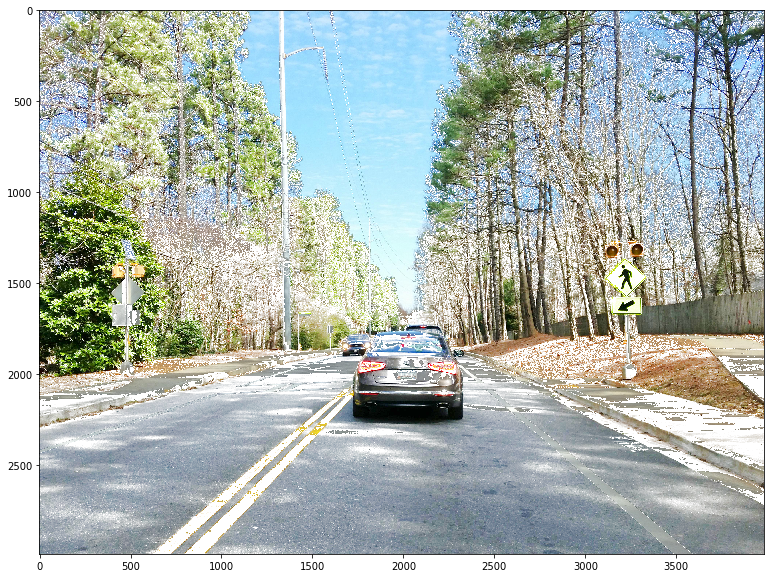

In [44]:
aug = albu.RandomSnow(p=1, brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5)
augment_and_show(aug, image)

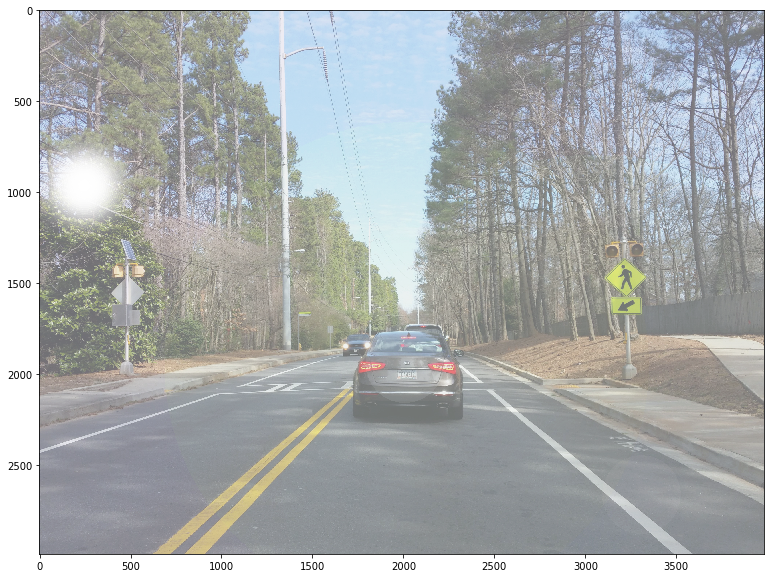

In [45]:
aug = albu.RandomSunFlare(p=1, flare_roi=(0, 0, 1, 0.5), angle_lower=0.5)

augment_and_show(aug, image)

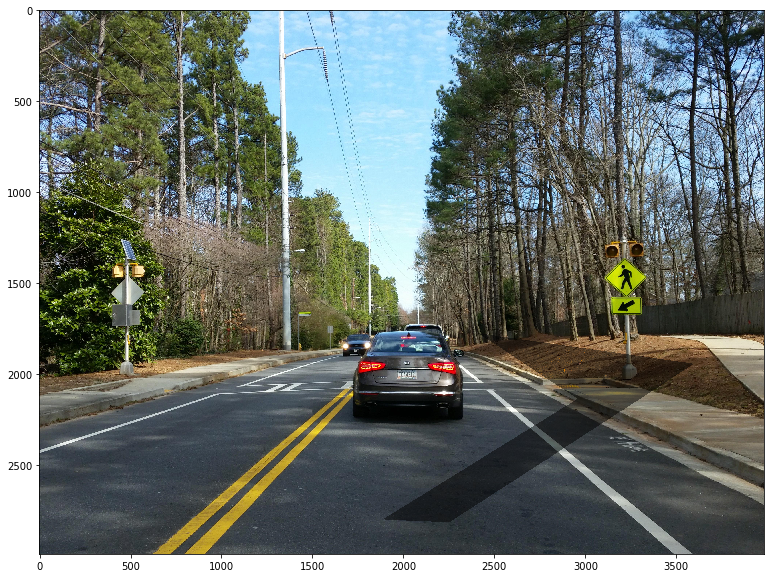

In [46]:
aug = albu.RandomShadow(p=1, num_shadows_lower=1, num_shadows_upper=1, 
                        shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1))

augment_and_show(aug, image)

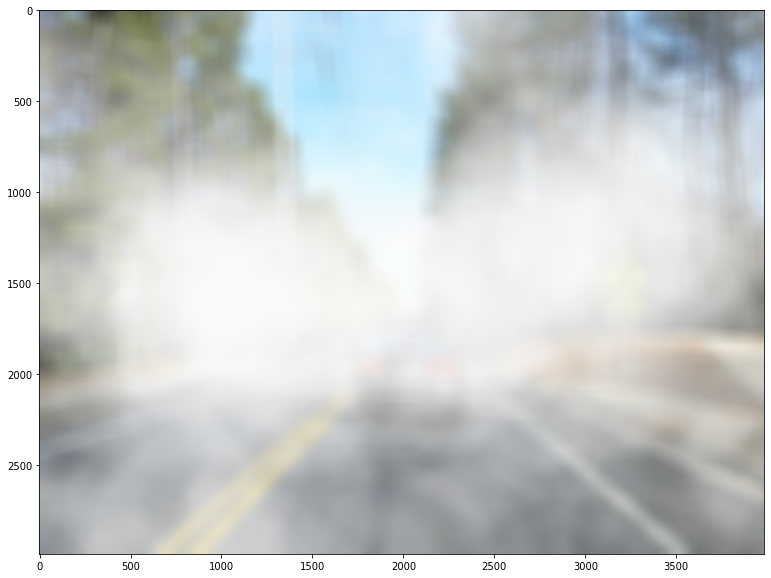

In [47]:
aug = albu.RandomFog(p=1, fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1)

augment_and_show(aug, image)